In [1]:
import sys
sys.path.insert(0, "..")

## Visualize Benchmark

In [2]:
import matplotlib.pyplot as plt
import torch

In [3]:
benchmark_data = torch.load('../benchmark_data/benchmark_high_noise_short.pt',weights_only=False)

In [4]:
benchmark_data.keys()

dict_keys(['tensors', 'category', 'pattern', 'length_config', 'description', 'params', 'series_length'])

In [5]:
bench_data = benchmark_data['tensors']

In [6]:
def plot_time_series(tensor, title=None, figsize=None):
      """
      Plot multiple time series in a subplot layout.

      Args:
          tensor: Tensor of shape [n, s] where n = number of series, s = length
          title: Optional overall figure title
          figsize: Optional tuple (width, height). Auto-calculated if None.

      Returns:
          fig, axes: The matplotlib figure and axes objects
      """
      if isinstance(tensor, torch.Tensor):
          tensor = tensor.numpy()

      n, s = tensor.shape

      # Calculate grid dimensions (prefer more rows than columns)
      cols = min(3, n)
      rows = (n + cols - 1) // cols

      if figsize is None:
          figsize = (4 * cols, 2.5 * rows)

      fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
      axes = axes.flatten()

      for i in range(n):
          axes[i].plot(tensor[i], linewidth=0.8)
          axes[i].set_title(f"Series {i+1}", fontsize=9)
          axes[i].set_xlabel("Time", fontsize=8)
          axes[i].set_ylabel("Value", fontsize=8)
          axes[i].tick_params(labelsize=7)

      # Hide unused subplots
      for i in range(n, len(axes)):
          axes[i].set_visible(False)

      if title:
          fig.suptitle(title, fontsize=11)

      plt.tight_layout()
      return fig, axes

(<Figure size 1200x750 with 9 Axes>,
 array([<Axes: title={'center': 'Series 1'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 2'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 3'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 4'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 5'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 6'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 7'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 8'}, xlabel='Time', ylabel='Value'>,
        <Axes: >], dtype=object))

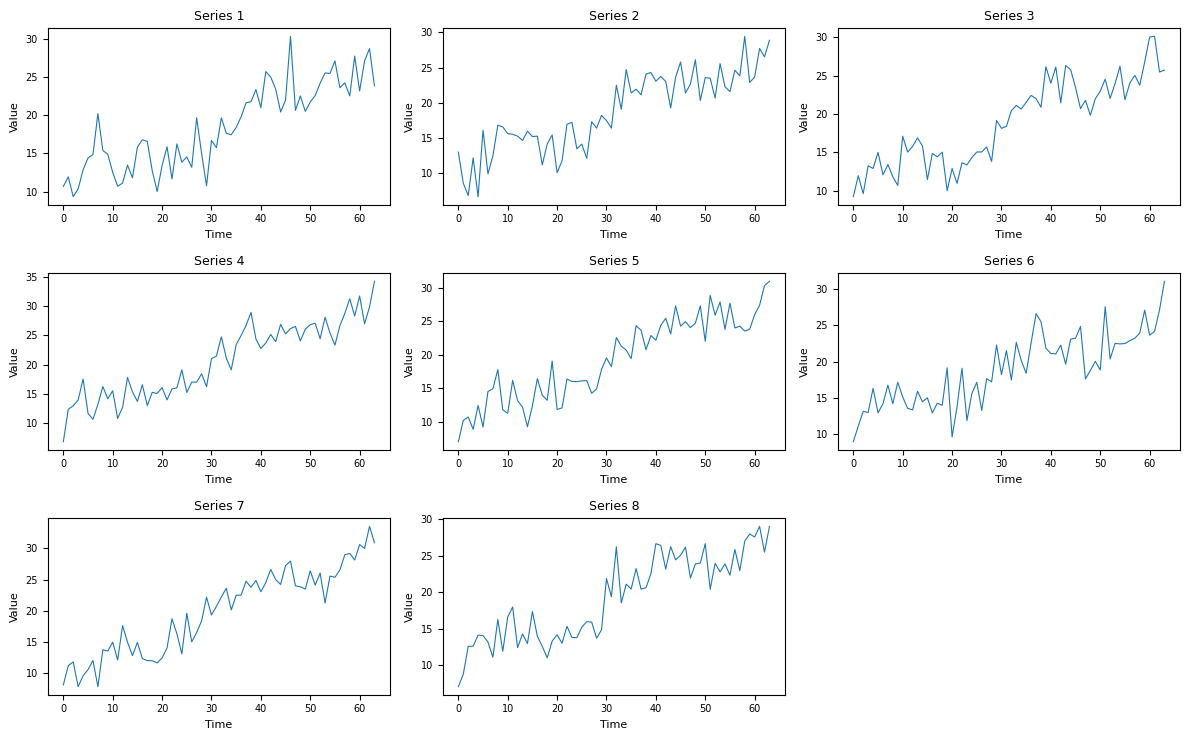

In [7]:
plot_time_series(bench_data[:8,:])

(<Figure size 1200x750 with 9 Axes>,
 array([<Axes: title={'center': 'Series 1'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 2'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 3'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 4'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 5'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 6'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 7'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 8'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'Series 9'}, xlabel='Time', ylabel='Value'>],
       dtype=object))

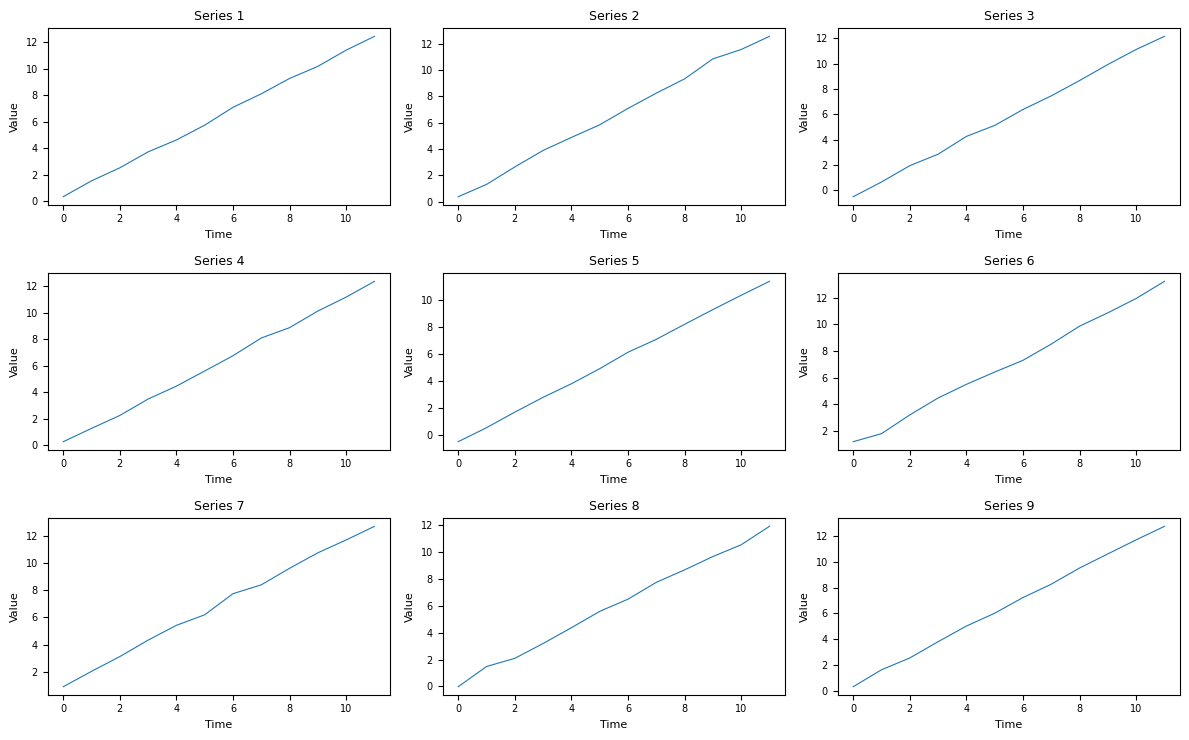

In [8]:
plot_time_series(torch.load('../benchmark_data/benchmark_strong_uptrend_medium.pt',weights_only=False)['tensors'][:9,:12])

## Load Model

In [9]:
from models.model import DecoderOnlyTransformer
from utils.core import get_causal_mask

In [10]:
model = DecoderOnlyTransformer(
        num_layers=4,
        model_dim=128,
        num_heads=8,
        hidden_dim=512,
        quantized_classes=103,
        padding_idx=102
    )
state_dict = torch.load("/home/pratikdoshi/projects/time-series/tsfm-archived/TSFM-After2000Steps/tsfm_9000.pt", weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
model.eval()

DecoderOnlyTransformer(
  (embedding): Embedding(103, 128, padding_idx=102)
  (pos_encoding): PositionalEncoding()
  (layers): ModuleList(
    (0-3): 4 x TransformerDecoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=512, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (dropout3): Dropout(p=0.1, inp

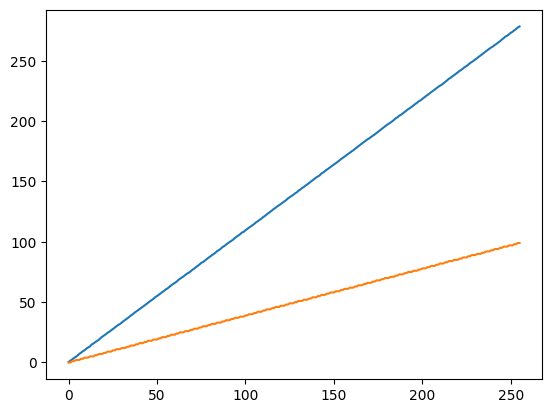

In [12]:
from data.dataset import generate_time_series, TSPreprocessor
data = torch.load('../benchmark_data/benchmark_strong_uptrend_medium.pt',weights_only=False)['tensors']
sample = data[0,:]
plt.plot(sample)


preprocessor = TSPreprocessor(num_classes=100)
x, meta = preprocessor.preprocess_series(sample.numpy())
plt.plot(x)

## Prediction

In [13]:
x_item = x[:-1].int()
y_item = x[1:].int()
x_item.shape, y_item.shape

(torch.Size([255]), torch.Size([255]))

In [14]:
for i in range(250,255):
    print(x_item[250:i+1], y_item[i])

tensor([97], dtype=torch.int32) tensor(97, dtype=torch.int32)
tensor([97, 97], dtype=torch.int32) tensor(98, dtype=torch.int32)
tensor([97, 97, 98], dtype=torch.int32) tensor(98, dtype=torch.int32)
tensor([97, 97, 98, 98], dtype=torch.int32) tensor(99, dtype=torch.int32)
tensor([97, 97, 98, 98, 99], dtype=torch.int32) tensor(99, dtype=torch.int32)


In [15]:
causal_mask = get_causal_mask(len(x_item))
with torch.no_grad():
    logits = model(x_item.unsqueeze(0), causal_mask)[0,:,:]

In [16]:
logits.shape

torch.Size([255, 103])

In [17]:
y_pred = logits.argmax(dim=-1)
y_pred.shape, x_item.shape, y_item.shape

(torch.Size([255]), torch.Size([255]), torch.Size([255]))

In [18]:
acc = (y_pred == y_item).sum() / y_item.numel()
print('Accuracy:',acc.item())

Accuracy: 1.0


## Visualizing the Prob Distribution

In [19]:
def visualize_dist(dist):
    x_axis = list(range(len(dist)))
    peak = dist.argmax().item()
    print('Next token:',dist.argmax())
    plt.bar(x=x_axis[peak-8:min(peak+25,len(x_axis))],height=dist[peak-8:min(peak+25,len(x_axis))])

tensor([97, 97, 97, 98, 98], dtype=torch.int32)
Next token: tensor(99)


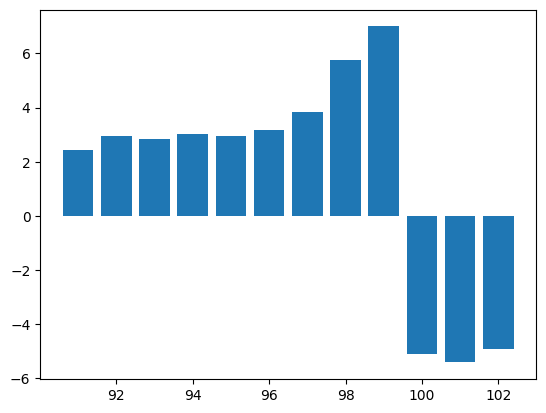

In [20]:
token_idx = 254
print(x_item[token_idx-5:token_idx])
visualize_dist(logits[token_idx,:])

## Model(x)[t,:] == Model(x[:t+1]) ?

In [21]:
x_item

tensor([ 0,  0,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,  7,
         7,  7,  8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 14,
        14, 14, 15, 15, 16, 16, 16, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 21,
        21, 21, 22, 22, 23, 23, 23, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 28,
        28, 28, 29, 29, 30, 30, 30, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 35,
        35, 35, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 40, 40, 40, 41, 41, 42,
        42, 42, 43, 43, 44, 44, 44, 45, 45, 46, 46, 46, 47, 47, 47, 48, 48, 49,
        49, 49, 50, 50, 51, 51, 51, 52, 52, 52, 53, 53, 54, 54, 54, 55, 55, 56,
        56, 56, 57, 57, 58, 58, 58, 59, 59, 59, 60, 60, 61, 61, 61, 62, 62, 62,
        63, 63, 64, 64, 64, 65, 65, 66, 66, 66, 67, 67, 68, 68, 68, 69, 69, 70,
        70, 70, 71, 71, 71, 72, 72, 73, 73, 73, 74, 74, 75, 75, 75, 76, 76, 76,
        77, 77, 78, 78, 78, 79, 79, 80, 80, 80, 81, 81, 82, 82, 82, 83, 83, 84,
        84, 84, 85, 85, 85, 86, 86, 87, 

In [30]:
model.eval()
t = 128

with torch.no_grad():
    full_out = model(x_item.unsqueeze(0), causal_mask)[0, t, :]
    prefix_mask = get_causal_mask(t+1)
    prefix_out = model(x_item[:t+1].unsqueeze(0), prefix_mask)[0, -1, :]
    
    diff = (full_out - prefix_out).abs().max()
    print(f"Max difference: {diff.item()}")  # should be ~0 or tiny (float precision)

Max difference: 8.917013168334961


Next token: tensor(50)


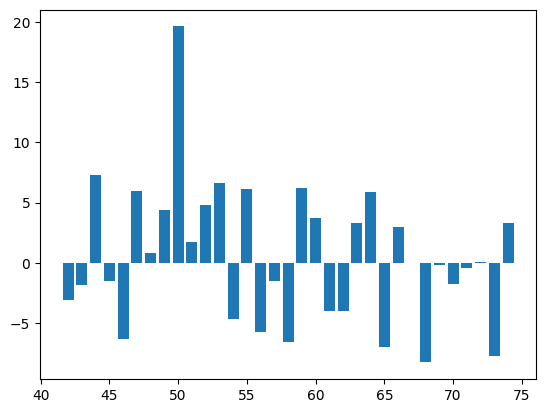

In [32]:
visualize_dist(full_out)

Next token: tensor(50)


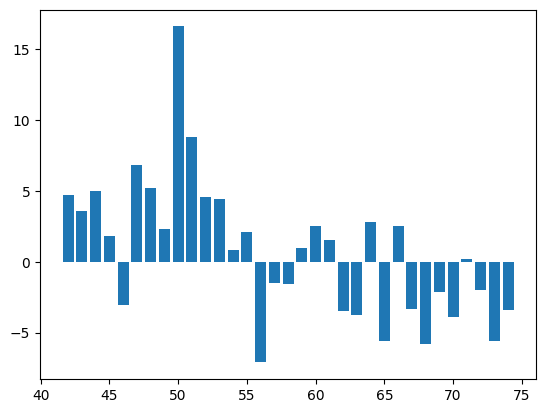

In [33]:
visualize_dist(prefix_out)

In [34]:
model.eval()
with torch.no_grad():
    # Try with t = 0 (first token can't see any future tokens anyway)
    full_out_0 = model(x_item.unsqueeze(0))[0, 0, :]
    prefix_out_0 = model(x_item[:1].unsqueeze(0))[0, -1, :]
    print(f"t=0 diff: {(full_out_0 - prefix_out_0).abs().max().item()}")
    
    # Try with last token (no future to peek at)
    T = x_item.shape[0]
    full_out_last = model(x_item.unsqueeze(0))[0, -1, :]
    prefix_out_last = model(x_item.unsqueeze(0))[0, -1, :]  # same input
    print(f"t=last diff: {(full_out_last - prefix_out_last).abs().max().item()}")

t=0 diff: 13.968792915344238
t=last diff: 0.0


In [36]:
model.training

False

## Checking if padding is the problem

In [39]:
# Use only real tokens, no padding
x_no_pad = x_item[x_item != preprocessor.PAD_TOKEN]
full_mask = get_causal_mask(len(x_no_pad))

full_out = model(x_no_pad.unsqueeze(0), full_mask)[0, t, :]
prefix_out = model(x_no_pad[:t+1].unsqueeze(0), get_causal_mask(t+1))[0, -1, :]

print(f"Max diff: {(full_out - prefix_out).abs().max().item()}")

Max diff: 8.917062759399414
